In [44]:
from stompy.grid import unstructured_grid
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# This one looks fine.
g=unstructured_grid.UnstructuredGrid.read_ugrid('./merge_v16_edit09-with_bathysmoothadcp.nc')

In [6]:
# This looks okay.
g=unstructured_grid.UnstructuredGrid.read_suntans('runs/large13_20180310')

In [8]:
# Looks okay.
g=unstructured_grid.UnstructuredGrid.read_ugrid('runs/large13_20180310/average.nc_0000.nc')

In [11]:
# Looks okay.
g=unstructured_grid.UnstructuredGrid.read_ugrid('runs/large13_20180310/ptm_average.nc_0000.nc')

In [27]:
ds=xr.open_dataset('runs/large13_20180330/ptm_average.nc_0000.nc')
# Maybe the cell is there, but it's missing bathy?
# Dialect doesn't seem to make a difference.
g=unstructured_grid.UnstructuredGrid.read_ugrid(ds,dialect='fishptm')

<IPython.core.display.Javascript object>


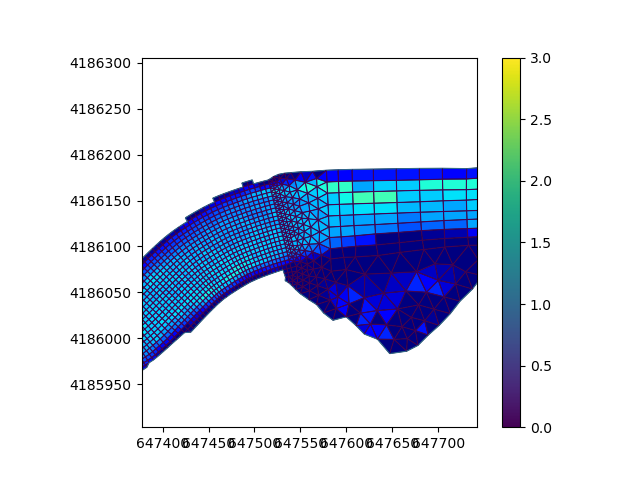

(647377.1668828824, 647741.8526872242, 4185903.393566019, 4186305.4830426006)

In [28]:
plt.figure()
g.plot_edges(color='k',lw=0.4)
g.plot_cells(values=ds.Mesh2_face_depth.values,cmap='jet')
plt.axis((647377.1668828824, 647741.8526872242, 4185903.393566019, 4186305.4830426006))

In [23]:
g.cells_area().min()

1.231689453125

In [18]:
plt.axis()

(647377.1668828824, 647741.8526872242, 4185903.393566019, 4186305.4830426006)

In [64]:
# This is the script Ed used for the conversion:
import pdb
import matplotlib.pyplot as plt
#from stompy.grid.unstructured_grid_to_ptm import UnstructuredGrid
from stompy.grid.unstructured_grid import UnstructuredGrid

#nc_file = r'..\20180310\ptm_average.nc_0000-002.nc'
nc_file='runs/large13_20180310/ptm_average.nc_0000.nc'
grd = UnstructuredGrid.from_ugrid(nc_file,dialect='fishptm')

<IPython.core.display.Javascript object>


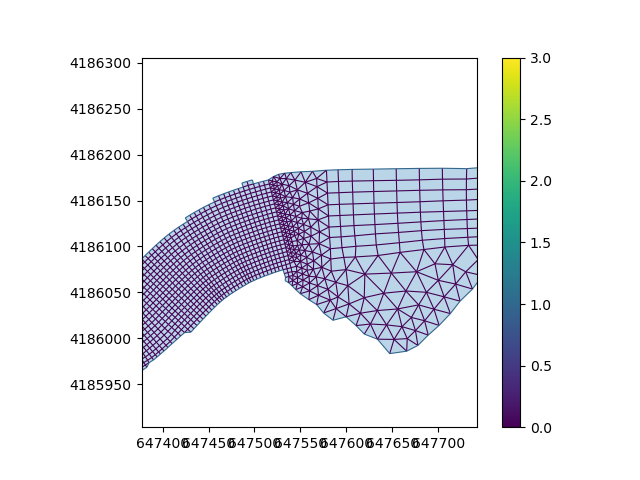

(647377.1668828824, 647741.8526872242, 4185903.393566019, 4186305.4830426006)

In [68]:
grd.update_cell_edges('all') # Try adding this in before writing.
grd.write_ptm_gridfile(fn='ptm_from_ugrid.grd',overwrite=True)
plt.figure()
eh = grd.plot_edges(values=grd.edges['mark'])
grd.plot_cells(alpha=0.3)
#grd.write_cells_shp('cells.shp')
#plt.ion()
#plt.show()
plt.gcf().colorbar(eh)
#pdb.set_trace()
plt.axis((647377.1668828824, 647741.8526872242, 4185903.393566019, 4186305.4830426006))

In [69]:
g_ptm=unstructured_grid.PtmGrid('ptm_from_ugrid.grd')

Reading vertices
Reading polygons
Reading sides


<IPython.core.display.Javascript object>


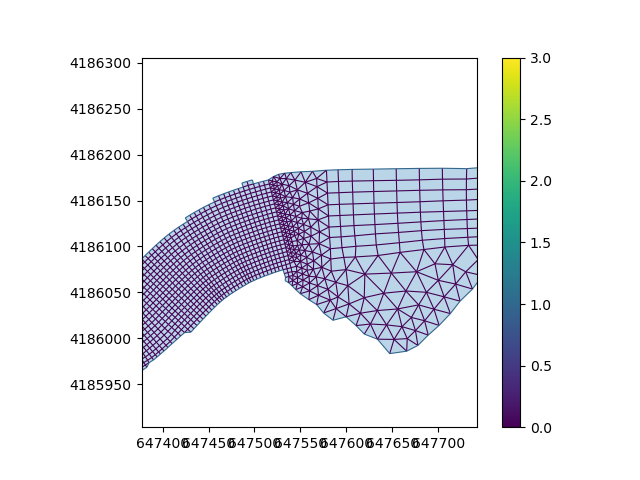

(647377.1668828824, 647741.8526872242, 4185903.393566019, 4186305.4830426006)

In [70]:
# Progress!
# This does recreate the issue.
plt.figure()
eh = g_ptm.plot_edges(values=g_ptm.edges['mark'])
g_ptm.plot_cells(alpha=0.3)
plt.colorbar(eh)
plt.axis((647377.1668828824, 647741.8526872242, 4185903.393566019, 4186305.4830426006))


In [71]:
grd.Ncells(), g_ptm.Ncells() # same number??


(18073, 18073)

In [47]:
grd.Nnodes(),g_ptm.Nnodes() # same
np.all(grd.nodes['x']==g_ptm.nodes['x']) # yes.
grd.cells['nodes'][0],g_ptm.cells['nodes'][0]

(array([6387, 6348, 6731, 6005], dtype=int32),
 array([6348, 6731, 6005, 6387], dtype=int32))

In [73]:
(g_ptm.cells_area().min(), # down to 0.
 grd.cells_area().min() ) # down to 1.23

(1.231689453125, 1.231689453125)

In [54]:
(g_ptm.cells_area()<=0.0).sum() # 51.
bad_cells=np.nonzero(g_ptm.cells_area()<=0.0)[0]
# These do line up with the cells that appear to be missing.

<IPython.core.display.Javascript object>


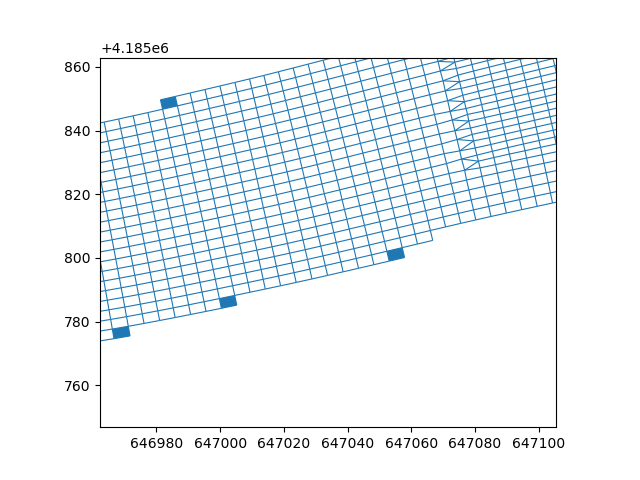

In [55]:
plt.figure()
grd.plot_edges()
grd.plot_cells(mask=bad_cells)

In [57]:
c=bad_cells[0]
grd.cells['nodes'][c], g_ptm.cells['nodes'][c]
# array([ 260, 6573,  881, 2798], dtype=int32),
# array([6573,   -1, 2798,   -1], dtype=int32))

(array([ 260, 6573,  881, 2798], dtype=int32),
 array([6573,   -1, 2798,   -1], dtype=int32))

In [60]:
grd.cells_center()[1184]

array([ 646968.92235, 4185776.616  ])

In [65]:
# So is it the writing or the reading that's off?
# Check the grd file.
# cell 1184 would polygon 1185 in the 1-based grd file
#        1185          4   646968.9223500  4185776.6160000 0.2745799 4774 4704 3199 4671  0
#        poly id       nsides cx cy   center depth    sides...sides  marker
# Center matches up with grd.
# So what's up with those sides?
# Side Data: side_number, side_depth, node_indices(2), cell_indices(2), marker
# 4774:       4774        0.2745799       6574        261       1179       1185          0
# 4704:       4704        0.2745799        882       6574       1160       1185          0
# 3199:       3199        0.2745799       2799        261       1185          0          1
# 4671:       4671        0.2745799        882       2799       1185          0          1
#  each edge has 1185 as a cell index.  good
#  From the edges, nodes are: [6574,261],[882,6574],[2799,261],[882,2799]
#  That's not in order.  Should it be? probably.

# write_ptm calls update_cell_edges(select='missing')

grd.cells['edges'][c] # 4773, 4703, 3198, 4670. 
# That's the same as in the ptm output. 



array([4773, 4703, 3198, 4670], dtype=int32)

In [67]:
grd.update_cell_edges('all')
grd.cells['edges'][c]

array([4773, 4703, 4670, 3198], dtype=int32)

<IPython.core.display.Javascript object>


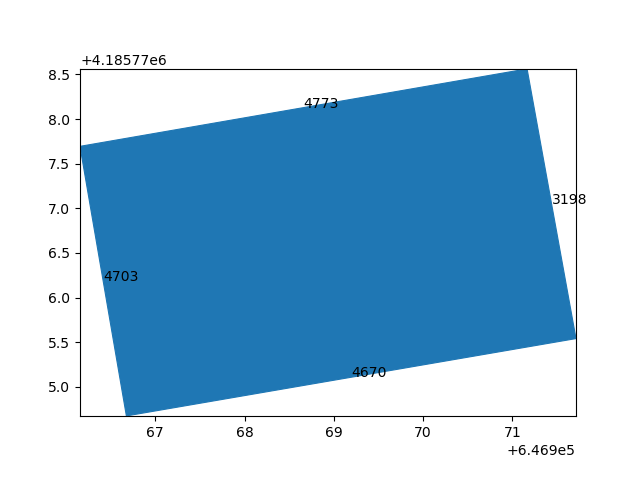

In [66]:
plt.figure()
grd.plot_cells(mask=[c])
grd.plot_edges(mask=grd.cells['edges'][c],labeler='id')
# 